# Generate Training Data
## Preparation

In [1]:
from scapy.all import *
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import logging

logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [3]:
# Formatters for displaying pandas data tables with columns of (lists of) scapy packets

def packet_list_fmt(lst):
    return f"{len(lst)} packets"

def packet_fmt(pkt):
    return pkt[DNS].summary()

In [4]:
ALGO_NAME = {
    0: 'unsigned',
    0: 0,
    5: 'rsasha1', 
    7: 'rsasha1nsec3sha1', 
    8: 'rsasha256', 
    10: 'rsasha512',
    13: 'ecdsap256sha256', 
    14: 'ecdsap384sha384', 
    15: 'ed25519', 
    16: 'ed448',
}
ALGO_NUM = {name: num for num, name in ALGO_NAME.items()}

In [5]:
# retrieve information encoded in DNS qnames

def split_qname(row):
    qname = row['qname']
    parts = qname.decode('ascii').split(".")
    try:
        if ".".join(parts[-3:]) == "dnstb.net.":
            if '-' not in parts[-4]:
                # this qname has a label directly under dnstb.net, store it
                # then remove to be compatible with qnames without label
                qlabel = parts[-4]
                del parts[-4]
            else:
                qlabel = ''
            
            resolver_parts = parts[-5].split("-")            
            if parts[-4] == 'unsigned':
                return {
                    'zone_algorithm': 0,
                    'zone_keysize': 0,
                    'zone_nsec': 0,
                    'zone_status': parts[-4],
                    'resolver': resolver_parts[2],
                    'qlabel': qlabel,                    
                }
            else:
                zone_parts = parts[-4].split("-")
                return {
                    'zone_algorithm': zone_parts[0],
                    'zone_keysize': zone_parts[1],
                    'zone_nsec': zone_parts[2],
                    'zone_status': zone_parts[3],
                    'resolver': resolver_parts[2],
                    'qlabel': qlabel,
                }
    except IndexError:
        logging.warning(f"could not split qname {qname} into meaningful information")
        return {
            'zone_algorithm': None,
            'zone_keysize': None,
            'zone_nsec': None,
            'zone_status': None,
            'resolver': None,
            'qlabel': None,
        }
    logging.warning(f"Could not split qname: {qname}")
    return {
        'zone_algorithm': None,
        'zone_keysize': None,
        'zone_nsec': None,
        'zone_status': None,
        'resolver': None,
        'qlabel': None,
    }

## Load Data

In [6]:
# load the traffic logs

c_logs = filter(lambda s: s, """
tcpdump_lab_ws2019_0xb_ens160_20210624190851.pcap
tcpdump_lab_ws2012r2_0x9_ens160_20210624190851.pcap
tcpdump_lab_powerdns460_0xe_ens160_20210624190851.pcap
tcpdump_lab_kresd532_0xd_ens160_20210624190851.pcap
tcpdump_lab_unbound167_0xf_ens160_20210624190851.pcap
tcpdump_lab_bind9113_0xc_ens160_20210624190851.pcap
tcpdump_lab_ws2016_0xa_ens160_20210624190851.pcap
tcpdump_lab_ws2012_0x8_ens160_20210624190851.pcap

tcpdump_opn-named_cloudflare_0x59_ens160_20210624190031.pcap
tcpdump_opn-named_yandex-dns-safe_0x68_ens160_20210624190031.pcap
tcpdump_opn-named_cisco-umbrella_0x58_ens160_20210624190031.pcap
tcpdump_opn-named_Comodo-secure-dns_0x5a_ens160_20210624190031.pcap
tcpdump_opn-named_cznic-odvr_0x5b_ens160_20210624190031.pcap
tcpdump_opn-named_google_0x5d_ens160_20210624190031.pcap
tcpdump_opn-named_norton-connectsafe_0x61_ens160_20210624190031.pcap
tcpdump_opn-named_verisgn-public-dns_0x66_ens160_20210624190031.pcap
tcpdump_opn-named_neustar-free-recursive_0x60_ens160_20210624190031.pcap
tcpdump_opn-named_quad9_0x64_ens160_20210624190031.pcap
tcpdump_opn-named_oracle-dyn_0x63_ens160_20210624190031.pcap
tcpdump_opn-named_opennic_0x62_ens160_20210624190031.pcap
tcpdump_opn-named_hurricane-electric_0x5e_ens160_20210624190031.pcap
tcpdump_opn-named_freenom-world_0x5c_ens160_20210624190031.pcap
""".split("\n"))

c_packets = reduce(lambda a,b: a + b, (rdpcap(f"../traffic/{f}") for f in c_logs))

In [7]:
# using the client logs, get a list of queries

queries = []
queries_by_id = {}
dropped = []

for p in c_packets:
    try:
        p[DNS]
    except IndexError:
        # ignore error if p is TCP packet
        # TODO find better way to ignore TCP acks
        try:
            p[TCP]
        except IndexError:
            logging.warning(f'Broken DNS packet at time {p.time}?')
        dropped.append(p)
        continue
    if p[DNS].qr == 0:
        # query
        qid = p[DNS].id
        q = {
            'id': qid,
            'qname': p[DNS].qd.qname,
            'tag': p[DNS].qd.qname.split(b'.', 1)[0],
            'started': p.time,
            'client_packets': [p],
            'server_packets': [],
        }
        queries.append(q)
        queries_by_id[qid] = q
    else:
        # response
        qid = p[DNS].id
        try:
            queries_by_id[qid]
        except KeyError:
            logging.warning(f"Response without query at time {p.time}")
            continue
        queries_by_id[qid]['finished'] = p.time
        queries_by_id[qid]['client_packets'].append(p)
    
queries = pd.DataFrame(queries)
queries['qname_parts'] = queries.apply(split_qname, axis=1)
for key in ['zone_algorithm', 'zone_keysize', 'zone_nsec', 'zone_status', 'resolver', 'qlabel']:
    queries[key] = queries.apply(lambda row: row['qname_parts'][key], axis=1)
del queries['qname_parts']

first_query_time, last_query_time = queries['started'].min(), queries['finished'].max()

In [8]:
len(queries), len(dropped)

(1033, 168)

In [9]:
queries['resolver'].unique(), queries['zone_algorithm'].unique()

(array([None, '20210624190851', 'cloudflare', 'yandex', 'cisco', 'Comodo',
        'cznic', 'google', 'norton', 'verisgn', 'neustar', 'quad9',
        'oracle', 'opennic', 'hurricane', 'freenom'], dtype=object),
 array([None, 'ecdsap256sha256', 'ecdsap384sha384', 'ed25519', 'ed448',
        'rsasha1', 'rsasha1nsec3sha1', 'rsasha256', 'rsasha512', 0],
       dtype=object))

In [10]:
s_logs = filter(lambda s: s, """
ns-eth0-lab-20210624170830.pcap
ns-eth0-opn-named-20210624170025.pcap
""".split("\n"))

"""
ns-eth0-opn-anon1-20210624172138.pcap
ns-eth0-opn-anon2-20210624172540.pcap
ns-eth0-opn-anon3-20210624173005.pcap
"""

s_packets = reduce(lambda a,b: a + b, (rdpcap(f"../traffic/{f}") for f in s_logs))

In [11]:
len(s_packets)

94747

## Match Client and Server Data

In [12]:
# using the server logs, match packets captured at the server to the client's questions

candidates = []

for p in tqdm(s_packets):
    if queries['started'].min() <= p.time <= queries['finished'].max():
        try:
            p_dns = tag = p[DNS]
        except IndexError:
            # ignore TCP packets (likely ACKs)
            try:
                p[TCP]
            except IndexError:
                logging.warning(f'packet with timestamp {p.time} could not be parsed as DNS packet')
            continue
        
        if p_dns.qd is None:
            logging.warning(f'packet with timestamp {p.time} did not contain a query name')
            continue
        
        qname_parts = p_dns.qd.qname.split(b'.')
        if len(qname_parts) < 4:
            continue
        qlabel = qname_parts[-4].decode()
        candidate_queries = (queries['started'] <= p.time) & (p.time <= queries['finished']) & (queries['qlabel'] == qlabel)
        if sum(candidate_queries) == 0:
            if b'signedok' in p_dns.qd.qname:
                logging.warning(f'Could not find candidates for query for {p_dns.qd.qname}, qlabel={qlabel}, p.time={p.time}')
            continue
        elif sum(candidate_queries) == 1:
            queries[candidate_queries].iloc[0]['server_packets'].append(p)
        else:
            logging.warning(f'Initial DNS query not uniquely identified for packet with time stamp {p.time}')
        

## Clean and Organize Data

In [13]:
queries['resolver'].unique()

array([None, '20210624190851', 'cloudflare', 'yandex', 'cisco', 'Comodo',
       'cznic', 'google', 'norton', 'verisgn', 'neustar', 'quad9',
       'oracle', 'opennic', 'hurricane', 'freenom'], dtype=object)

In [14]:
# drop rows that do not have exactly two client packets

queries['num_client_packets'] = queries.apply(lambda row: len(row['client_packets']), axis=1)
drop = queries['num_client_packets'] != 2
if sum(drop):
    logging.warning(f'Dropping {sum(drop)} of {len(queries)} queries as they do not have exactly two client packets')
    for count, num in zip(*np.unique(queries['num_client_packets'], return_counts=True)):
        if count == 2: continue
        logging.warning(f'- {num} queries had {count} client packet(s)')
queries = queries.drop(queries[drop].index)

queries['client_query'] = queries.apply(lambda row: row['client_packets'][0], axis=1)
queries['client_response'] = queries.apply(lambda row: row['client_packets'][1], axis=1)
del queries['client_packets']

In [15]:
queries['client_response_rcode'] = queries.apply(lambda row: row['client_response'].rcode, axis=1)
queries['client_response_ad'] = queries.apply(lambda row: row['client_response'].ad, axis=1)

In [16]:
# TODO: select server packet(s) for feature extraction

def take_first_query(packet_list):
    queries = filter(lambda p: p[DNS].qr == 0, packet_list)
    try:
        return next(iter(queries))
    except StopIteration:
        return None

queries['num_server_packets'] = queries.apply(lambda row: len(row['server_packets']), axis=1)
queries['server_query'] = queries.apply(lambda row: take_first_query(row['server_packets']), axis=1)

In [17]:
drop = queries['server_query'].isnull()
if sum(drop):
    logging.warning(f"Dropping {sum(drop)} of {len(queries)} queries as corresponding server packets could not be found!")
    queries = queries.drop(queries[drop].index)

In [18]:
queries['validated_response'] = (queries['client_response_rcode'] == 0) & (queries['client_response_ad'] == 1)
queries['rc0&ad1'] = queries['validated_response']
queries['rc0'] = queries['client_response_rcode'] == 0

In [19]:
queries['resolver'].unique()

array(['20210624190851', 'cloudflare', 'yandex', 'cisco', 'Comodo',
       'cznic', 'google', 'norton', 'verisgn', 'neustar', 'quad9',
       'oracle', 'opennic', 'hurricane', 'freenom'], dtype=object)

In [20]:
queries['num_server_packets'].min(), queries['num_server_packets'].mean(), queries['num_server_packets'].max(), queries['num_server_packets'].unique()

(2,
 28.058100558659216,
 1626,
 array([   8,    6,    4,   12,    7,    2,    5,   14,   16,   10,   20,
          18,   22,   24,   46,   44,   26,   36,   15,   28,   30,   48,
          32,   40,   34,   38,   52,  152,  154,  156,  188, 1626,   98,
         148,   54,  368,  542,   80,  244,   62,  258,  242,   86,  132,
          76,  134]))

## Extract Features and Label

In [21]:
# set the label

queries['label_rcode'] = queries['client_response_rcode']
queries['label_resolver'] = queries['resolver']
queries['label_rcode0andad1'] = queries['validated_response']

In [22]:
# set some features

queries['feature_ip_ttl'] = queries.apply(lambda row: row['server_query'][IP].ttl, axis=1)
queries['feature_ip_src'] = queries.apply(lambda row: row['server_query'][IP].src, axis=1)
queries['feature_ip_proto'] = queries.apply(lambda row: row['server_query'][IP].proto, axis=1)
queries['feature_ip_df'] = queries.apply(lambda row: row['server_query'][IP].flags == 2, axis=1)
queries['feature_ip_ihl'] = queries.apply(lambda row: row['server_query'][IP].ihl, axis=1)
queries['feature_ip_id_is_zero'] = queries.apply(lambda row: row['server_query'][IP].id == 0, axis=1)
#queries['feature_udp_len'] = queries.apply(lambda row: row['server_query'][UDP].len, axis=1)
queries['feature_dns_qr'] = queries.apply(lambda row: row['server_query'][DNS].qr, axis=1)
queries['feature_dns_opcode'] = queries.apply(lambda row: row['server_query'][DNS].opcode, axis=1)
queries['feature_dns_aa'] = queries.apply(lambda row: row['server_query'][DNS].aa, axis=1)
queries['feature_dns_tc'] = queries.apply(lambda row: row['server_query'][DNS].tc, axis=1)
queries['feature_dns_rd'] = queries.apply(lambda row: row['server_query'][DNS].rd, axis=1)
queries['feature_dns_ra'] = queries.apply(lambda row: row['server_query'][DNS].ra, axis=1)
queries['feature_dns_z'] = queries.apply(lambda row: row['server_query'][DNS].z, axis=1)
queries['feature_dns_cd'] = queries.apply(lambda row: row['server_query'][DNS].cd, axis=1)
queries['feature_dns_rcode'] = queries.apply(lambda row: row['server_query'][DNS].rcode, axis=1)
queries['feature_dns_qdcount'] = queries.apply(lambda row: row['server_query'][DNS].qdcount, axis=1)
queries['feature_dns_ancount'] = queries.apply(lambda row: row['server_query'][DNS].ancount, axis=1)
queries['feature_dns_nscount'] = queries.apply(lambda row: row['server_query'][DNS].nscount, axis=1)
queries['feature_dns_arcount'] = queries.apply(lambda row: row['server_query'][DNS].arcount, axis=1)
queries['feature_dns_edns_requestors_udp_payload_size'] = queries.apply(lambda row: row['server_query'][DNS].ar.rclass, axis=1)
queries['feature_dns_0x20'] = queries.apply(lambda row: row['server_query'][DNS].qd.qname.lower() != row['server_query'][DNS].qd.qname and row['server_query'][DNS].qd.qname.upper() != row['server_query'][DNS].qd.qname, axis=1)
queries['feature_dns_edns_num_extra_attributes'] = queries.apply(lambda row: len(row['server_query'][DNS].ar.rdata), axis=1)
assert queries['feature_dns_edns_num_extra_attributes'].max() == 1
queries['feature_dns_edns_optcode'] = queries.apply(lambda row: row['server_query'][DNS].ar.rdata[0].optcode if row['feature_dns_edns_num_extra_attributes'] == 1 else -1, axis=1)
assert set(queries['feature_dns_edns_optcode'].unique()).issubset({-1, 8, 10}), set(queries['feature_dns_edns_optcode'].unique())
queries['feature_dns_edns_cookie'] = queries['feature_dns_edns_optcode'] == 10
queries['feature_dns_edns_subnet'] = queries['feature_dns_edns_optcode'] == 8
del queries['feature_dns_edns_num_extra_attributes']
del queries['feature_dns_edns_optcode']

In [23]:
for algo in queries['zone_algorithm'].unique():
    print(f'++++{algo}++++')
    for c in filter(lambda c: c.startswith('feature_'), queries.keys()):
        u = np.unique(queries[(queries['zone_algorithm'] == algo)][c], return_counts=True)
        if len(u[0]) > 1:
            print(f"{c}: {len(u[0])} unique values")

++++ecdsap256sha256++++
feature_ip_ttl: 9 unique values
feature_ip_src: 20 unique values
feature_ip_df: 2 unique values
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 9 unique values
feature_dns_0x20: 2 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
++++ecdsap384sha384++++
feature_ip_ttl: 10 unique values
feature_ip_src: 21 unique values
feature_ip_df: 2 unique values
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 8 unique values
feature_dns_0x20: 2 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
++++ed25519++++
feature_ip_ttl: 10 unique values
feature_ip_src: 20 unique values
feature_ip_df: 2 unique values
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 8 unique values
feature_dns_0x20: 2 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
++++ed448++++
fe

## Show Data
### All Columns

In [24]:
queries[queries['zone_status'] == 'signedok'].iloc[-10:].style.format({'server_packets': packet_list_fmt, 'client_query': packet_fmt, 'client_response': packet_fmt, 'server_query': packet_fmt})

,id,qname,tag,started,server_packets,finished,zone_algorithm,zone_keysize,zone_nsec,zone_status,resolver,qlabel,num_client_packets,client_query,client_response,client_response_rcode,client_response_ad,num_server_packets,server_query,validated_response,rc0&ad1,rc0,label_rcode,label_resolver,label_rcode0andad1,feature_ip_ttl,feature_ip_src,feature_ip_proto,feature_ip_df,feature_ip_ihl,feature_ip_id_is_zero,feature_dns_qr,feature_dns_opcode,feature_dns_aa,feature_dns_tc,feature_dns_rd,feature_dns_ra,feature_dns_z,feature_dns_cd,feature_dns_rcode,feature_dns_qdcount,feature_dns_ancount,feature_dns_nscount,feature_dns_arcount,feature_dns_edns_requestors_udp_payload_size,feature_dns_0x20,feature_dns_edns_cookie,feature_dns_edns_subnet
1022,23110,b'opn-named-freenom-world-20210624190031.rsasha256-4096-1-signedok.5c.dnstb.net.',b'opn-named-freenom-world-20210624190031',1624554184.378842,36 packets,1624554190.222106,rsasha256,4096,1,signedok,freenom,5c,2,"DNS Qry ""b'opn-named-freenom-world-20210624190031.rsasha256-4096-1-signedok.5c.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,1,36,"DNS Qry ""b'5c.dnstb.net.'""",True,True,True,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1023,58112,b'opn-named-freenom-world-20210624190031.rsasha256-4096-3-signedok.5c.dnstb.net.',b'opn-named-freenom-world-20210624190031',1624554190.222378,34 packets,1624554195.652308,rsasha256,4096,3,signedok,freenom,5c,2,"DNS Qry ""b'opn-named-freenom-world-20210624190031.rsasha256-4096-3-signedok.5c.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,1,34,"DNS Qry ""b'5c.dnstb.net.'""",True,True,True,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1024,591,b'opn-named-freenom-world-20210624190031.rsasha512-1024-1-signedok.5c.dnstb.net.',b'opn-named-freenom-world-20210624190031',1624554195.652580,32 packets,1624554200.428187,rsasha512,1024,1,signedok,freenom,5c,2,"DNS Qry ""b'opn-named-freenom-world-20210624190031.rsasha512-1024-1-signedok.5c.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,1,32,"DNS Qry ""b'5c.dnstb.net.'""",True,True,True,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1025,47771,b'opn-named-freenom-world-20210624190031.rsasha512-1024-3-signedok.5c.dnstb.net.',b'opn-named-freenom-world-20210624190031',1624554200.428426,34 packets,1624554205.539208,rsasha512,1024,3,signedok,freenom,5c,2,"DNS Qry ""b'opn-named-freenom-world-20210624190031.rsasha512-1024-3-signedok.5c.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,1,34,"DNS Qry ""b'5c.dnstb.net.'""",True,True,True,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1026,25195,b'opn-named-freenom-world-20210624190031.rsasha512-1871-1-signedok.5c.dnstb.net.',b'opn-named-freenom-world-20210624190031',1624554205.539455,32 packets,1624554210.309607,rsasha512,1871,1,signedok,freenom,5c,2,"DNS Qry ""b'opn-named-freenom-world-20210624190031.rsasha512-1871-1-signedok.5c.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,1,32,"DNS Qry ""b'5c.dnstb.net.'""",True,True,True,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1027,39611,b'opn-named-freenom-world-20210624190031.rsasha512-1871-3-signedok.5c.dnstb.net.',b'opn-named-freenom-world-20210624190031',1624554210.309862,34 packets,1624554215.469788,rsasha512,1871,3,signedok,freenom,5c,2,"DNS Qry ""b'opn-named-freenom-world-20210624190031.rsasha512-1871-3-signedok.5c.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,1,34,"DNS Qry ""b'5c.dnstb.net.'""",True,True,True,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1028,52567,b'opn-named-freenom-world-20210624190031.rsasha512-2048-1-signedok.5c.dnstb.net.',b'opn-named-freenom-world-20210624190031',1624554215.470060,32 packets,1624554220.214205,rsasha512,2048,1,signedok,freenom,5c,2,"DNS Qry ""b'opn-named-freenom-world-20210624190031.rsasha512-2048-1-signedok.5c.dnstb.net.'""",

In [25]:
def validation_info(data):
    n = len(queries)
    for rcode in data['client_response_rcode'].unique():
        for ad in data['client_response_ad'].unique():
            c = sum((queries['client_response_rcode'] == rcode) & (queries['client_response_ad'] == ad))
            print(f"{c}/{n} ({c/n:.1%}) have rcode={rcode} ad={ad}")
            
print('all queries')
validation_info(queries)

print('signedok queries')
validation_info(queries[queries['zone_status'] == 'signedok'])

all queries
619/895 (69.2%) have rcode=0 ad=1
137/895 (15.3%) have rcode=0 ad=0
4/895 (0.4%) have rcode=2 ad=1
135/895 (15.1%) have rcode=2 ad=0
signedok queries
619/895 (69.2%) have rcode=0 ad=1
137/895 (15.3%) have rcode=0 ad=0
4/895 (0.4%) have rcode=2 ad=1
135/895 (15.1%) have rcode=2 ad=0


In [26]:
def validation_success_rate(c):
    return sum(c == 1) / len(c)

def sr(c):
    return float(sum(c == 1) / len(c))

In [27]:
queries['zone_keysize'] = queries['zone_keysize'].astype(np.int)

In [28]:
resolvers = set(queries['resolver'].unique())
resolvers_lab = {'bind9113',
 'powerdns460',
 'unbound167',
 'kresd',
 'ws2012',
 'ws2012r2',
 'ws2016',
 'ws2019'}
resolvers_named_open = resolvers - resolvers_lab
resolver_order = list(sorted(resolvers_lab)) + list(sorted(resolvers_named_open))
resolver_order

['bind9113',
 'kresd',
 'powerdns460',
 'unbound167',
 'ws2012',
 'ws2012r2',
 'ws2016',
 'ws2019',
 '20210624190851',
 'Comodo',
 'cisco',
 'cloudflare',
 'cznic',
 'freenom',
 'google',
 'hurricane',
 'neustar',
 'norton',
 'opennic',
 'oracle',
 'quad9',
 'verisgn',
 'yandex']

In [29]:
def validation_status_color(val):
    if np.isnan(val):
        return 'color: grey'
    color = 'red' if val < 1 else 'black'
    return 'color: %s' % color

def best_algo(c):
    cnum = list(map(lambda name: ALGO_NUM[name], c))
    return ALGO_NAME[max(cnum)]

pd.options.display.precision = 0

resolver_support = queries[
    (queries['zone_status'] == 'signedok')  # only valid signatures / secure zones
    & ~((queries['zone_nsec'] == '3') & (queries['zone_algorithm'] == 'rsasha1'))  # ignore nsec3 with rsasha1
    #& ~(queries['resolver'].isin(['freenom', 'opennic', 'quad9']))  # ignore resolvers with measurement/analysis errors
].groupby(['resolver', 'zone_algorithm', 'zone_keysize', 'zone_nsec']).agg({
    #'id': ['count'],
    'rc0&ad1': [sr],
}).reset_index()
resolver_best = resolver_support[resolver_support[('rc0&ad1', 'sr')] > .5].groupby(['resolver']).agg({
    'zone_algorithm': [best_algo]
}).sort_values(['resolver'], key=lambda r: list(map(lambda e: resolver_order.index(e), r)), kind='mergesort')
resolver_best.to_pickle('resolver_best.pickle')
resolver_best

,zone_algorithm
,best_algo
resolver,
20210624190851,ecdsap384sha384
Comodo,ed448
cisco,ed448
cloudflare,ed25519
cznic,ed25519
freenom,ecdsap384sha384
google,ed25519
neustar,rsasha512


In [30]:
def response_status(row):
    rs = {
        (0, 1): 'validated',
        (0, 0): 'insecure', 
        (2, 0): 'failure',
        (2, 1): 'failure ad',
    }
    return rs[(row['client_response_rcode'], row['client_response_ad'])]

def single_value(c):
    c = set(c)
    if len(c) == 0:
        return None
    if len(c) == 1:
        return next(iter(c))
    return(set(c))
    raise ValueError(c)

def security_status_color(val):
    if isinstance(val, float) and math.isnan(val):
        color = 'grey'
    else:
        color = 'green' if val == 'validated' else 'red'
    #print(type(val), val, color)        
    return 'color: %s' % color

def latex_symbol(val):
    if val == 'validated':
        return r'\cmark'
    elif val == 'insecure':
        return r'\xmark'
    else:
        return val
        raise ValueError()

queries['resolver response'] = queries.apply(response_status, axis=1)
queries['key size'] = queries['zone_keysize']
queries['algorithm'] = queries['zone_algorithm']
queries['nsec'] = queries['zone_nsec']

resolver_support = queries[
    (queries['zone_status'] == 'signedok')  # only valid signatures / secure zones
    & (queries['zone_nsec'] == '1')  # only NSEC1
    & ~((queries['zone_nsec'] == '3') & (queries['zone_algorithm'] == 'rsasha1'))  # ignore nsec3 with rsasha1
    & ~(queries['zone_keysize'] > 2048)  # ignore large key sizes
    & ~(queries['zone_algorithm'].isin(['rsasha1', 'rsasha1nsec3sha1', 'rsasha256', 'rsasha512']) & (queries['zone_keysize'] < 2048))  # ignore small rsa keys
    & ~(queries['zone_algorithm'] == 'rsasha1nsec3sha1')  # ignore weird algorithms
    & ~(queries['resolver'].isin(['freenom', 'opennic', 'quad9']))  # ignore resolvers with measurement/analysis errors
].groupby(['resolver', 'algorithm', 'key size', 'nsec']).agg({
    #'id': ['count'],
    'resolver response': [single_value],
}).reset_index().sort_values(['key size']).sort_values(by=['algorithm'], key=lambda c: c.apply(
    lambda zone_algorithm: ALGO_NUM[zone_algorithm]), kind='mergesort').pivot(
    ['resolver'], ['algorithm', 'key size'], ['resolver response']).sort_values(
    ['resolver'], key=lambda r: list(map(lambda e: resolver_order.index(e), r)), kind='mergesort')

print(resolver_support.to_latex(
    formatters={
        c: latex_symbol
        for c in resolver_support.keys()
    },
    escape=False,
    column_format='lcccccc',
))
resolver_support.style.applymap(security_status_color)

\begin{tabular}{lcccccc}
\toprule
{} & \multicolumn{7}{l}{resolver response} \\
algorithm &           rsasha1 & rsasha256 & rsasha512 & ecdsap256sha256 & ecdsap384sha384 &                    ed25519 &                      ed448 \\
key size &              2048 &      2048 &      2048 &            256  &            384  &                       256  &                       456  \\
resolver       &                   &           &           &                 &                 &                            &                            \\
\midrule
20210624190851 &            \cmark &    \cmark &    \cmark &          \cmark &          \cmark &  {'validated', 'insecure'} &  {'validated', 'insecure'} \\
Comodo         &            \cmark &    \cmark &    \cmark &          \cmark &          \cmark &                     \cmark &                     \cmark \\
cisco          &            \cmark &    \cmark &    \cmark &          \cmark &          \cmark &                     \cmark &                 

In [31]:
drop = queries['resolver'] == 'hurricane'
if sum(drop):
    logging.warning(f"Dropping {sum(drop)} of {len(queries)} queries!")
    queries = queries.drop(queries[drop].index)

### ML Columns

In [32]:
# collect columns relevant for ML
ML = list(filter(lambda c: c.startswith('label_') or c.startswith('feature_'), queries.keys()))

In [33]:
# collect rows relevant for ML
signedok = queries['zone_status'] == 'signedok'

In [34]:
# save table to disk
for algorithm in queries['zone_algorithm'].unique():
    queries[signedok & (queries['zone_algorithm'] == algorithm)].to_pickle(f'ml_data_{algorithm}.pickle')

In [35]:
%%bash
ls -lh ml_data_*.pickle

-rw-rw-r-- 1 nils nils 2.4K Jun 24 23:01 ml_data_0.pickle
-rw-rw-r-- 1 nils nils 971K Jun 24 23:01 ml_data_ecdsap256sha256.pickle
-rw-rw-r-- 1 nils nils 396K Jun 24 23:01 ml_data_ecdsap384sha384.pickle
-rw-rw-r-- 1 nils nils 381K Jun 24 23:01 ml_data_ed25519.pickle
-rw-rw-r-- 1 nils nils 544K Jun 24 23:01 ml_data_ed448.pickle
-rw-rw-r-- 1 nils nils 1.6M Jun 24 23:01 ml_data_rsasha1nsec3sha1.pickle
-rw-rw-r-- 1 nils nils 1.4M Jun 24 23:01 ml_data_rsasha1.pickle
-rw-rw-r-- 1 nils nils 1.6M Jun 24 23:01 ml_data_rsasha256.pickle
-rw-rw-r-- 1 nils nils 1.6M Jun 24 23:01 ml_data_rsasha512.pickle


In [36]:
# show table
queries[signedok][ML].iloc[-10:].style.format({'server_packets': packet_list_fmt, 'client_query': packet_fmt, 'client_response': packet_fmt})

,label_rcode,label_resolver,label_rcode0andad1,feature_ip_ttl,feature_ip_src,feature_ip_proto,feature_ip_df,feature_ip_ihl,feature_ip_id_is_zero,feature_dns_qr,feature_dns_opcode,feature_dns_aa,feature_dns_tc,feature_dns_rd,feature_dns_ra,feature_dns_z,feature_dns_cd,feature_dns_rcode,feature_dns_qdcount,feature_dns_ancount,feature_dns_nscount,feature_dns_arcount,feature_dns_edns_requestors_udp_payload_size,feature_dns_0x20,feature_dns_edns_cookie,feature_dns_edns_subnet
1022,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1023,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1024,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1025,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1026,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1027,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1028,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1029,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1030,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False
1031,0,freenom,True,54,103.200.218.77,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,1232,False,False,False


In [37]:
sum(signedok)

838

### Some Data Insights

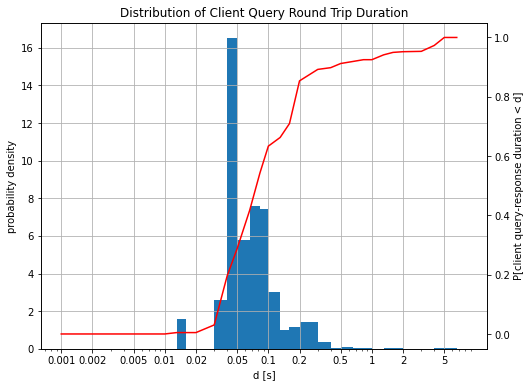

In [38]:
# client query duration distribution

queries['duration'] = queries['finished'] - queries['started']

data = queries['duration'].astype(np.float).dropna()
bins = [b*10**p for p in [-3, -2, -1, 0] for b in [1,1.3,1.6,2,3,4,5,6.6,8.3]]
labels = bins[::3]
hist, bin_edges = np.histogram(data, bins=bins)
cdf = np.cumsum(hist)

plt.figure(figsize=(8, 6))
plt.grid(True)

ax, tax = plt.gca(), plt.twinx()

ax.hist(data, bins=bins, density=True)
ax.set_ylabel('probability density')
ax.set_xlabel('d [s]')

tax.plot(bin_edges[:-1], cdf/cdf[-1], c='r')
tax.set_ylabel('P[client query-response duration < d]')

plt.xscale('log')
plt.xticks(labels, map(str, labels))
plt.title('Distribution of Client Query Round Trip Duration')

None

In [39]:
# show a single query to the server

for p in queries.iloc[200]['server_packets']:
    if p[DNS].qr != 0:
        continue
    print(p[IP].show())

###[ IP ]### 
  version   = 4
  ihl       = 5
  tos       = 0x0
  len       = 94
  id        = 35738
  flags     = 
  frag      = 0
  ttl       = 51
  proto     = udp
  chksum    = 0x85f8
  src       = 141.12.128.13
  dst       = 130.149.230.77
  \options   \
###[ UDP ]### 
     sport     = 43102
     dport     = domain
     len       = 74
     chksum    = 0x9db3
###[ DNS ]### 
        id        = 9034
        qr        = 0
        opcode    = QUERY
        aa        = 0
        tc        = 0
        rd        = 0
        ra        = 0
        z         = 0
        ad        = 0
        cd        = 1
        rcode     = ok
        qdcount   = 1
        ancount   = 0
        nscount   = 0
        arcount   = 1
        \qd        \
         |###[ DNS Question Record ]### 
         |  qname     = 'rsasha512-1871-3-signedok.f.dnstb.net.'
         |  qtype     = DNSKEY
         |  qclass    = IN
        an        = None
        ns        = None
        \ar        \
         |###[ DNS OPT Re